In [185]:
import cv2
import numpy as np
from scipy.fftpack import dct, idct
import matplotlib.pyplot as plt
from skimage import io, metrics

In [186]:
img = cv2.cvtColor(cv2.imread('../uploads/lenna.png'), cv2.COLOR_BGR2RGB)

In [187]:
def toBlocks(img, xLen, yLen, h, w):
    blocks = np.zeros((yLen,xLen,h,w,3),dtype=np.int16)
    for y in range(yLen):
        for x in range(xLen):
            blocks[y][x]=img[y*h:(y+1)*h,x*w:(x+1)*w]
    return np.array(blocks)

def blocks2img(blocks, xLen, yLen, h, w):
    W   = xLen*w
    H   = yLen*h
    img = np.zeros((H,W,3))
    for y in range(yLen):
        for x in range(xLen):
            img[y*h:y*h+h,x*w:x*w+w]=blocks[y][x]
    return img

def dctOrDedctAllBlocks(blocks, yLen, xLen, h, w,type="dct"):
    f=dct if type=="dct" else idct
    dedctBlocks = np.zeros((yLen,xLen,h,w,3))
    for y in range(yLen):
        for x in range(xLen):
            d = np.zeros((h,w,3))
            for i in range(3):
                block=blocks[y][x][:,:,i]
                d[:,:,i]=f(f(block.T, norm = 'ortho').T, norm = 'ortho')
                if (type!="dct"):
                    d=d.round().astype(np.int16)
            dedctBlocks[y][x]=d
    return dedctBlocks

In [219]:
rows, cols, channels = img.shape
mean = 0
std_dev = 20 # Điều chỉnh độ lớn của nhiễu Gaussian
noise = np.random.normal(mean, std_dev, (rows, cols, channels))
# Thêm nhiễu vào ảnh
noisy_image = np.clip(img + noise, 0, 255).astype(np.uint8)

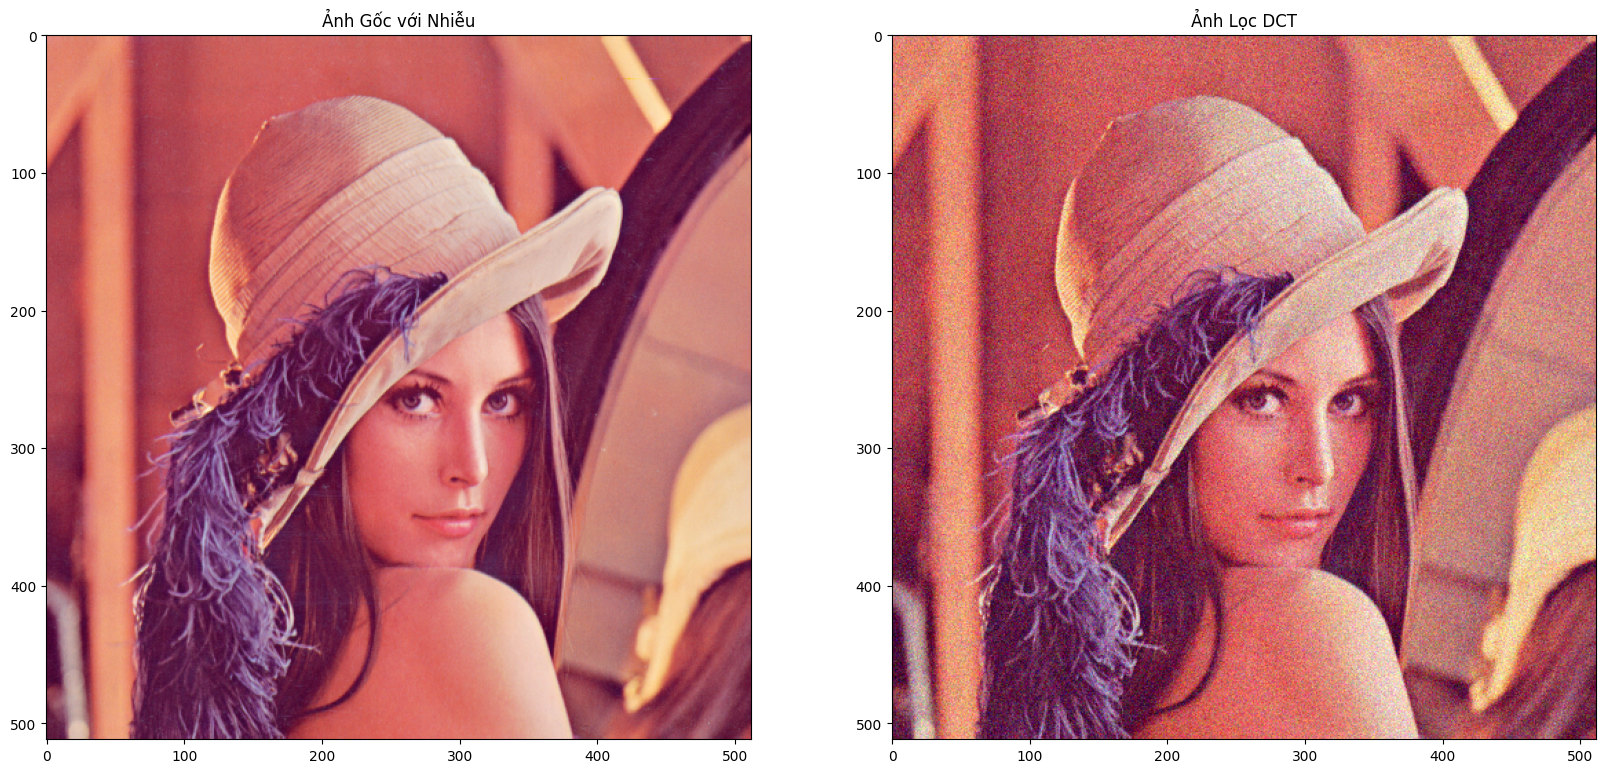

In [220]:
fig, axes = plt.subplots(1, 2, figsize=(20, 20))
axes[0].imshow(img)
axes[0].set_title('Ảnh Gốc với Nhiễu')
axes[1].imshow(noisy_image)
axes[1].set_title('Ảnh Lọc DCT')
plt.show()

In [221]:
DCTbasis3x3 = np.array([
    [   0.5773502588272094726562500000000000000000,
        0.5773502588272094726562500000000000000000,
        0.5773502588272094726562500000000000000000,     ],
    [  0.7071067690849304199218750000000000000000,
      0.0000000000000000000000000000000000000000,
      -0.7071067690849304199218750000000000000000, ],
    [
        0.4082483053207397460937500000000000000000,
        -0.8164966106414794921875000000000000000000,
        0.4082483053207397460937500000000000000000      ]
])

def ColorTransform(img, DCTbasis3x3, flag=1):
    image_flat = img.reshape(-1, 3)
    if flag == 1:
        transformed_image_flat = np.dot(image_flat, DCTbasis3x3.T)
    else:
        transformed_image_flat = np.dot(image_flat, DCTbasis3x3)
    transformed_image_flat = transformed_image_flat.reshape(img.shape)
    return transformed_image_flat

In [222]:
w = 8 #modify it if you want, maximal 8 due to default quantization table is 8*8
h = w
xLen = img.shape[1]//w
yLen = img.shape[0]//h
image_trans = ColorTransform(noisy_image, DCTbasis3x3, flag=1)
blocks_denosing = toBlocks(image_trans, xLen, yLen, h, w)
dct_blocks_denoising = dct(dct(blocks_denosing, axis=2, norm='ortho'), axis=3, norm='ortho')
threshold = std_dev * 3
dct_blocks_filtered = np.where(np.abs(dct_blocks_denoising) < threshold, 0, dct_blocks_denoising)
filtered_blocks = idct(idct(dct_blocks_filtered, axis=2, norm='ortho'), axis=3, norm='ortho')
newImg=blocks2img(filtered_blocks, xLen, yLen, h, w)
newImg = ColorTransform(newImg, DCTbasis3x3, flag=-1)
newImg = np.clip(newImg, 0, 255).astype(np.uint8)

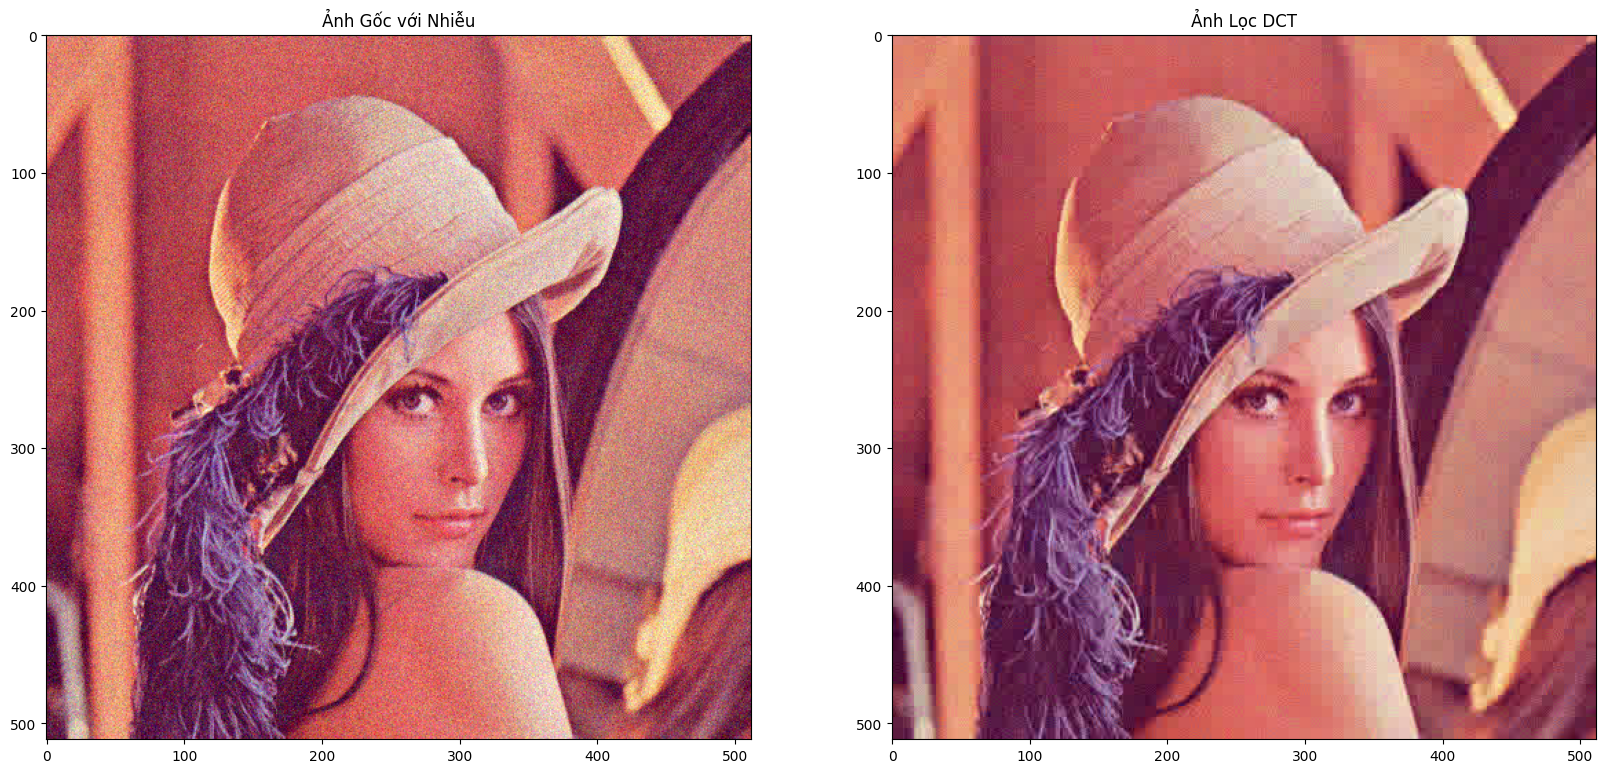

In [223]:
fig, axes = plt.subplots(1, 2, figsize=(20, 20))
axes[0].imshow(noisy_image)
axes[0].set_title('Ảnh Gốc với Nhiễu')
axes[1].imshow(newImg)
axes[1].set_title('Ảnh Lọc DCT')
plt.show()

In [224]:
w = 8 #modify it if you want, maximal 8 due to default quantization table is 8*8
h = w
xLen = img.shape[1]//w
yLen = img.shape[0]//h
blocks_denosing = toBlocks(noisy_image, xLen, yLen, h, w)
dct_blocks_denoising = dct(dct(blocks_denosing, axis=2, norm='ortho'), axis=3, norm='ortho')
threshold = std_dev * 3
dct_blocks_filtered = np.where(np.abs(dct_blocks_denoising) < threshold, 0, dct_blocks_denoising)
filtered_blocks = idct(idct(dct_blocks_filtered, axis=2, norm='ortho'), axis=3, norm='ortho')
newImg2 =blocks2img(filtered_blocks, xLen, yLen, h, w)
newImg2 = np.clip(newImg2, 0, 255).astype(np.uint8)

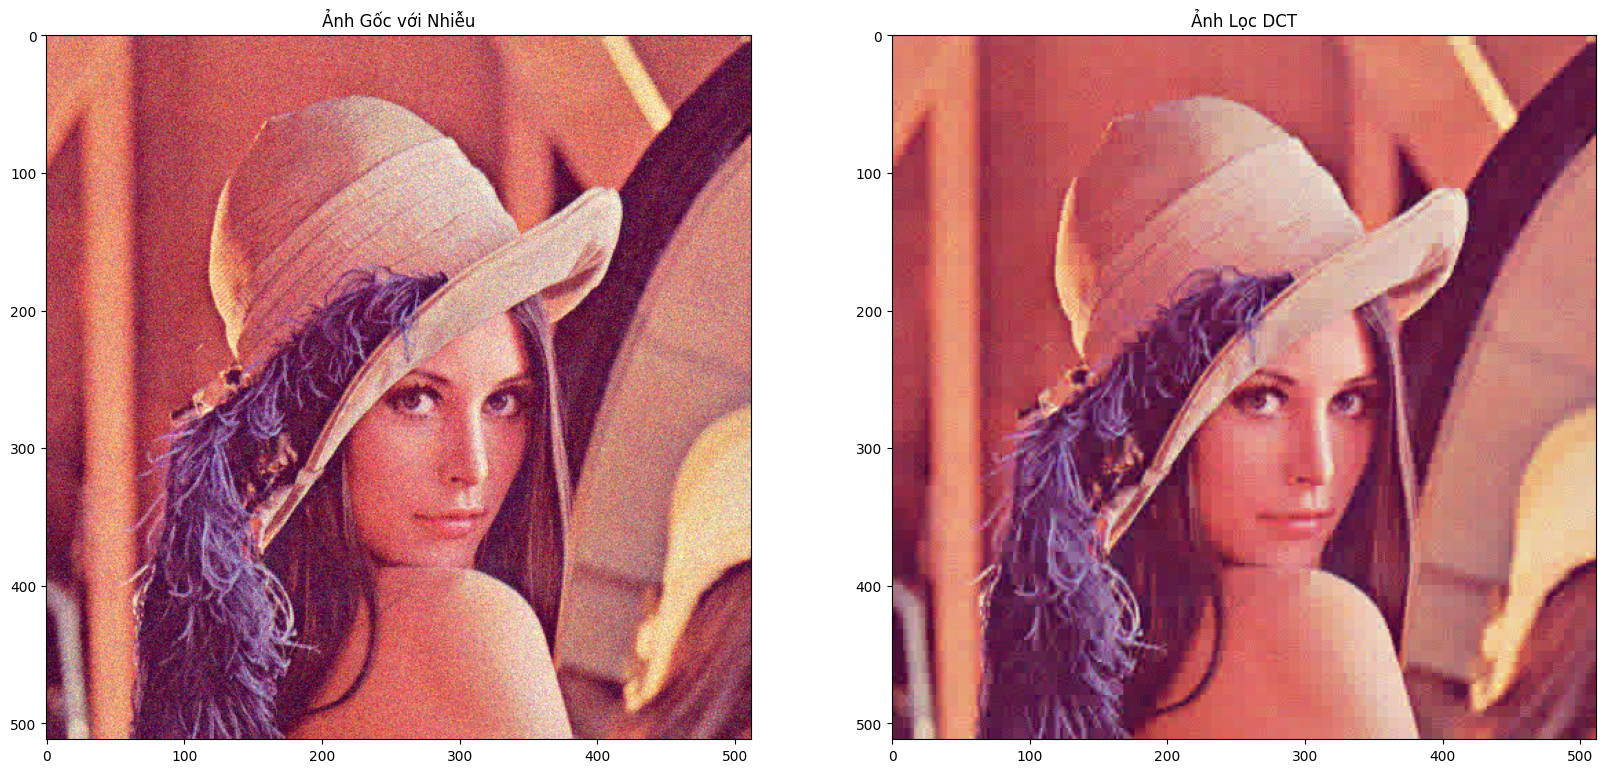

In [225]:
fig, axes = plt.subplots(1, 2, figsize=(20, 20))
axes[0].imshow(noisy_image)
axes[0].set_title('Ảnh Gốc với Nhiễu')
axes[1].imshow(newImg2)
axes[1].set_title('Ảnh Lọc DCT')
plt.show()

In [226]:
print("PSNR: ", metrics.peak_signal_noise_ratio(img, noisy_image))
print("MSE: ", metrics.mean_squared_error(img, noisy_image))
print("SSIM: ", metrics.structural_similarity(img, noisy_image,win_size=3))

PSNR:  22.238868748854486
MSE:  388.32333246866864
SSIM:  0.8770216852981279


In [227]:
print("PSNR: ",metrics.peak_signal_noise_ratio(img, newImg))
print("MSE: ", metrics.mean_squared_error(img, newImg))
print("SSIM: ", metrics.structural_similarity(img, newImg,win_size=3))

PSNR:  28.99927429108855
MSE:  81.87530517578125


SSIM:  0.971711678929694


In [228]:
print("PSNR: ",metrics.peak_signal_noise_ratio(img, newImg2))
print("MSE: ", metrics.mean_squared_error(img, newImg2))
print("SSIM: ", metrics.structural_similarity(img, newImg2,win_size=3))

PSNR:  28.279499119717165
MSE:  96.63410949707031
SSIM:  0.9667633103953988
